# Chocolate Classifier

Most of the explanations I give here are taken from the fantastic fastai (v3) course, specifically lessons 1 & 2.
If you're interested in learning how to do projects like this by yourself: https://course.fast.ai/.

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We import all the necessary packages. We are going to work with the [fastai V1 library](http://www.fast.ai/2018/10/02/fastai-ai/) which sits on top of [Pytorch 1.0](https://hackernoon.com/pytorch-1-0-468332ba5163). The fastai library provides many useful functions that enable us to quickly and easily build neural networks and train our models.

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, and pick a smaller batch-size, perhaps 32, or 16.

Reminder: a great batch-size will help the model learn *faster*, but it also consumes more memory. The advantage of batching is that we mitigate the noise that the model learns from single samples. It turns out that updating the weights every X samples cancels out most of the noise! And of course, back-propping less means less time spent learning.

In [3]:
bs = 64

## Looking at the data

I scraped my dataset from Google Images, here is a wonderful guide for doing just that: https://medium.com/@intprogrammer/how-to-scrape-google-for-images-to-train-your-machine-learning-classifiers-on-565076972ce

In general, the dataset is composed of two classes, chocolate, and not chocolate. I downloaded images of chocolate, and white chocolate for the chocolate class. And for the not-chocolate class, I went for a variety of different kinds of images: pets, people, selfies, furniture, food, and some random stuff.

Because Google Image cap is somewhere around 800 per query, I had to use different languages when looking for images for the model (i.e. English, Spanish, Russian, etc...)

The folder variable tells us where we want the images saved. The 'download_images' function will pull the urls from 'url_file', and place it in 'folder.

These three steps should be repeated as many times as the CSV files we have. The only changes we should make is to the 'folder' (different class), and to the 'url_file'.

In [4]:
folder = 'chocolate'
url_file = 'chocolate_icecream_heb.csv'

In [5]:
path = Path('data/Chocolate Dataset')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [30]:
download_images(path/url_file, dest)

Error http://chocolateworkshop.co.il/wp-content/uploads/2013/06/Ice_cream.jpg HTTPConnectionPool(host='chocolateworkshop.co.il', port=80): Max retries exceeded with url: /wp-content/uploads/2013/06/Ice_cream.jpg (Caused by ProtocolError('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer')))
Error http://www.artcream.co.il/sysvault/sysnewsfiles/%20.jpg HTTPConnectionPool(host='www.artcream.co.il', port=80): Max retries exceeded with url: /sysvault/sysnewsfiles/%20.jpg (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f13790a7b00>: Failed to establish a new connection: [Errno -2] Name or service not known',))
Error https://mi0.rightinthebox.com/images/384x384/201407/gjklji1404732233283.jpg HTTPSConnectionPool(host='mi0.rightinthebox.com', port=443): Read timed out. (read timeout=4)
Error https://lookaside.fbsbx.com/lookaside/crawler/media/?media_id=1031480670368934 HTTPSConnectionPool(host='www.facebook.com', port=443): Read timed out.

# Some cleaning -- let's remove all the images that can't be opened  

In [6]:
classes = ['chocolate', 'not_chocolate']

'verify_images' will check what images can't be opened, and if it finds one, it deletes it. Without it, our model may run into some trouble!

In [7]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

chocolate


not_chocolate


This is not one of the allowed sizes of this image


The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the foldernames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_folder`.

In [7]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224,num_workers=4).normalize(imagenet_stats)


In [8]:
# # If you already cleaned your data, run this cell instead of the one before 
# np.random.seed(42)
# data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
#         ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Let's take a quick glance over the images we have:

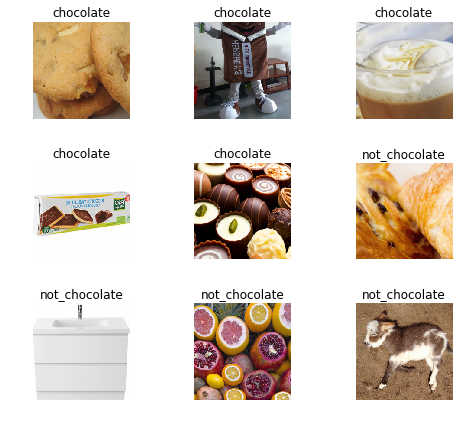

In [10]:
data.show_batch(rows=3, figsize=(7,6))

Note that some of the images have a wrong label, we will try to fix it later.

In [11]:
print(data.classes)
len(data.classes),data.c

['chocolate', 'not_chocolate']


(2, 2)

## Training: resnet34

Now we will start training our model. We will use a pretrained resnet34. 
I have also gave a pretrained resnet50 a shot, but it did not perform better. I believe that it is because I did not download enough data to help such a deep network to generalize.

Reminder: we are not looking for chocolate bars, we are looking for anything that has some sort of chocolate in it. The inherit problem of this task is that unlike say, cats, chocolate has many forms (think icecream, chocolate bar, chocolate popcorn, white chocolate). Eventually, the model achieved good results, but it is important to remember that it is by no means reliable. To change that, we need much more data, and make sure it is clean!

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

We can take a peek into the model's structure with learn.model:

In [13]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

We run the training set for two, or three epochs, using one-cycle-policy,. Cyclic learning is a new way to tune the learning rate, and there's a great post about it here: https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6. 

As a general rule of thumb, we should train the model until the validation-loss stops decreasing. There is more to it than that, but it's a good rule of thumb. If we choose to continue training the model only to see some very small changes in the validation-loss, and a continuous decrease in the training set, we are overfitting our model, and should rollback to our model.

In [14]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.574690,0.277352,0.111635,00:59
1,0.417538,0.246422,0.103774,01:00
2,0.347801,0.236451,0.103774,00:58
3,0.283453,0.235096,0.095912,00:57


Before we view the results, and further tune the model, we should probably save the weights we learned so far (you can find this file in the "models" folder).

In [15]:
learn.save('stage-1-34')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not.

In [16]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

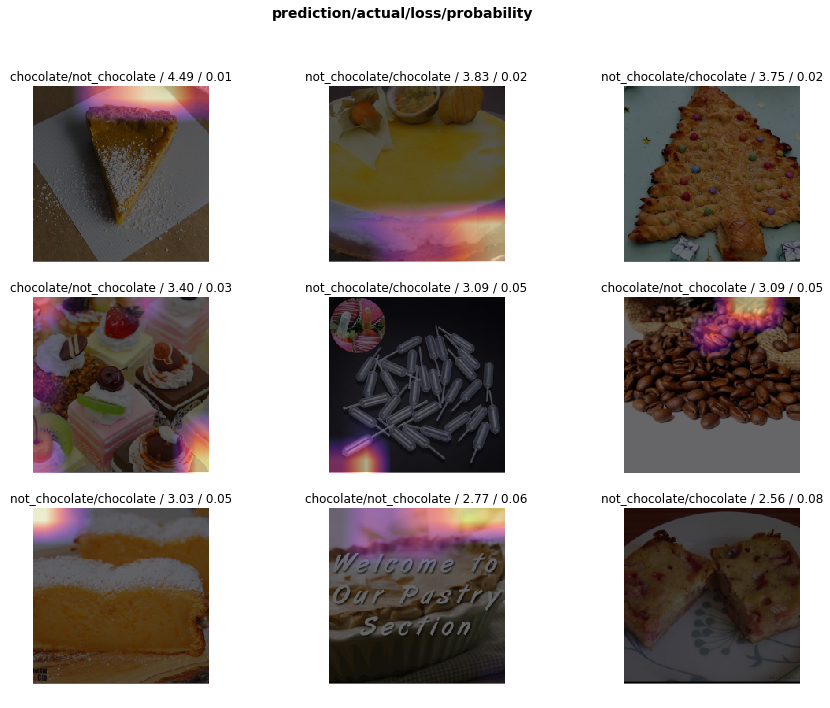

In [17]:
interp.plot_top_losses(9, figsize=(15,11))

Some mistakes are really obvious, like the hot peppers bottle, but for some reason the model thought otherwise. On other cases, the labeling is plain wrong. Look at the person that is labeled as a chocolate!

In [18]:
doc(interp.plot_top_losses)

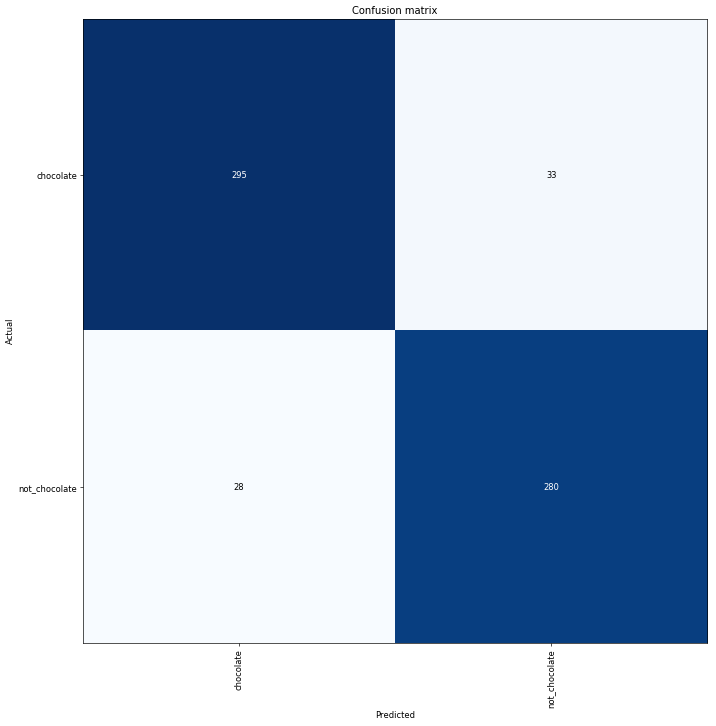

In [19]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

From the confusion matrix we can see that the false positives, and negatives distribution is pretty balanced. But we can probably do a little better with fine-tuning, and cleaning the data a little bit.

## Some more cleaning!

Since our dataset is composed of Google Images without any special filtering, we can probably do better than what we currently achieve simply by cleaning some of the data, and build a new model.

In [25]:
from fastai.widgets import *

In [26]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [27]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

The DatasetFormatter does most of the heavy-lifting for us! It pulls the top losses of our model, and asks us whether we want to delete some of the images, or change their class. It is not always the case, but it is possible that some of the data we downloaded is plain wrong. I.e. a chocolate label for an image of a building is something we should probably fix by changing the image's class to "not chocolate". And so on. So, we can choose to delete an image if it does more harm than good, for example, a tiny piece of chocolate next to a bunch of people is just plain confusing for our model.

It's important to remember: in our case, most of the mistakes the model made are food related, perhaps we could have achieved better results by adding more food related data.

In [28]:
learn_cln.load('stage-1-34');

In [29]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [30]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Let's load the clean dataset, and see if we can improve our results even further

In [12]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [13]:
learn_cln = cnn_learner(data, models.resnet34, metrics=error_rate)
learn_cln.load('stage-1-34');

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [14]:
learn_cln.unfreeze()

In [15]:
learn_cln.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.318902,0.278794,0.127760,01:12


Uh-oh, so we saw that unfreezing our model, and then training it again will not do any good to our model. That is true because we are at the fine-tuning stage, and we can't be agressive about the way we train our network, unlike the situation we had when initially training our model. Instead, we should use a great tool called 'lr_find', it helps us find an appropriate learning rate (instead of the default one that was used in the line above). We ask the method to try different learning rates, and plot them for us. Then, we can check the graph, and pick a better learning rate for our task.

Let's roll back the changes we made in the line above.

In [16]:
learn_cln.load('stage-1-34');

In [17]:
learn_cln.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


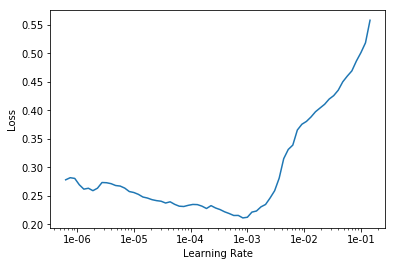

In [18]:
learn_cln.recorder.plot()

Great! We have a plot of the loss, over the learning rate. Let's pick a range of learning rates and train on that! As a rule of thumb, we should *not* aim for the lowest point in the plot, but aim for the lowest point in the plot that is within a range of values that continue to decrease.

In [19]:
learn_cln.unfreeze()
learn_cln.fit_one_cycle(1, max_lr=slice(1e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.302762,0.275535,0.091483,01:07


Wow, so our model looks much better now! Let's interpret the results and save its state.

## Let's see the difference:

In [80]:
interp_cln = ClassificationInterpretation.from_learner(learn_cln)

losses,idxs = interp_cln.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

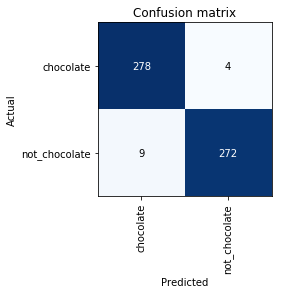

In [81]:
interp_cln.plot_confusion_matrix()

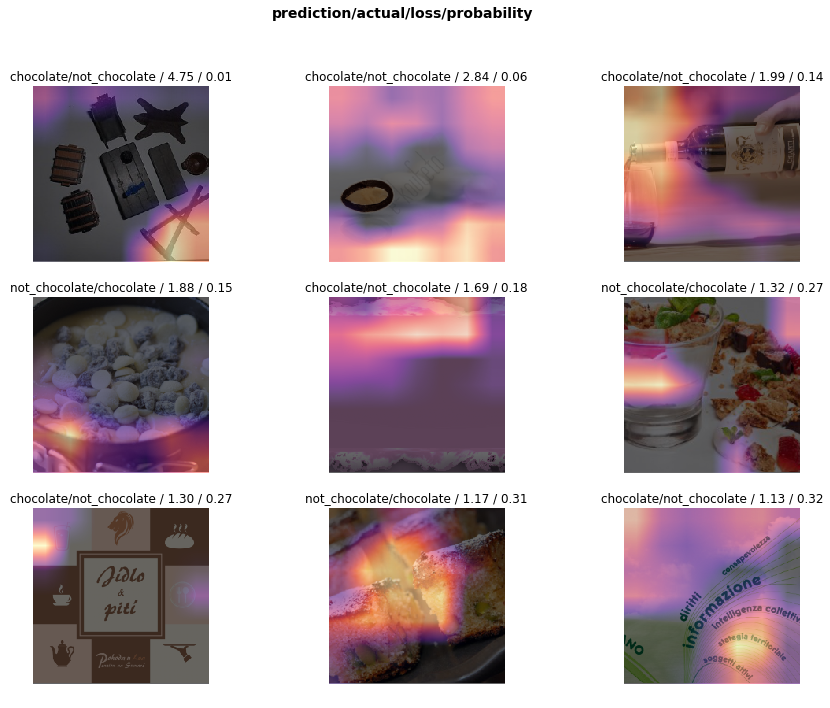

In [82]:
interp_cln.plot_top_losses(9, figsize=(15,11))

Some of the top losses are actually images that I decided to change their class, for example, the white candle that says 'white chocolate', I don't think a human would classify the candle as chocolate-like, but I can understand why the network thinks so. In addition, the muffin displayed on the second row can be thought of as a chocolate muffin, but we can't know for sure. 

## We're done training the model!

To conclude, we managed to scrape off another 0.4% error rate by fine-tuning and cleaning the data. It is quite possible that with further we work we would have managed to do even better.

In general, we would probably get much better results if we were to use at least 5000 samples per class, or something along those lines.

In [20]:
learn_cln.export()

In [21]:
learn_cln.save('stage-2-34')